In [34]:
from data_loading import get_loaders
from model_bb import Yo4o, DarkNet, Yo1o, Yo3o, Yo2o
from helper import compute_iou, compute_ats_bounding_boxes
from loss import Loss
import pickle 
import os
from torchvision import transforms


import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import kornia
from torchvision import models

from models import resnet34_encoderdecoder
from helper import draw_box

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

In [42]:
model = Yo2o()

In [43]:
print('num of trainable params:', sum(p.numel() for p in model.parameters() if p.requires_grad)) 


num of trainable params: 188284352


In [41]:
189418096

189418096

In [3]:
trainloader, valloader = get_loaders('labeled', batch_size = 1)
# sample, target, road_image, path = iter(trainloader).next()
device = torch.device('cuda')
# img_batch = torch.stack(sample).to(device)

In [3]:
darknet = Yo1o().to(device)

In [3]:
sample, target, road_image = iter(trainloader).next()
img_batch = torch.stack(sample).to(device)

In [5]:
darknet(img_batch).shape

torch.Size([1, 20, 20, 10])

In [63]:
class Yo4o(nn.Module):
    '''ResNet Backbone'''
    def __init__(self, feature_size = 20, num_bboxes = 2, device = 'cuda', load_pretrained = False):
        super().__init__()

        self.feature_size = feature_size
        self.num_bboxes = num_bboxes
        self.device = device

        self.M_matrices = torch.tensor([
        # CAM_FRONT_LEFT
        [[-6.92946073e-02, -1.17143003e+00,  1.64122408e+02],
           [-1.33781874e-14, -1.67019853e+00,  2.34084846e+02],
           [-7.00394603e-17, -7.63146706e-03,  1.00000000e+00]],
        # CAM_FRONT
        [[-6.92636526e-02, -1.17089785e+00,  1.64264194e+02],
           [-1.12965193e-14, -1.66944201e+00,  2.34140507e+02],
           [-5.76795556e-17, -7.62799727e-03,  1.00000000e+00]],
        # CAM_FRONT_RIGHT
        [[-7.02452787e-02, -1.17762492e+00,  1.64369634e+02],
           [-2.27595720e-14, -1.67903365e+00,  2.34318471e+02],
           [-1.16009632e-16, -7.67182090e-03,  1.00000000e+00]],
        # CAM_BACK_LEFT
        [[-6.94775392e-02, -1.17675499e+00,  1.64135286e+02],
           [-1.19904087e-14, -1.67779415e+00,  2.34164782e+02],
           [-5.78963960e-17, -7.66615368e-03,  1.00000000e+00]],
        # CAM_BACK
        [[-6.82085369e-02, -1.16228084e+00,  1.64011808e+02],
           [-1.23234756e-14, -1.65715610e+00,  2.33912863e+02],
           [-6.39679282e-17, -7.57186452e-03,  1.00000000e+00]],
        # CAM_BACK_RIGHT
        [[-6.91003275e-02, -1.16814423e+00,  1.63997347e+02],
           [-1.59872116e-14, -1.66551463e+00,  2.34087152e+02],
           [-8.30498864e-17, -7.61006318e-03,  1.00000000e+00]]
           ]).to(self.device)

        if load_pretrained:
            resnet = torch.load('../self-sup/resnet34_pretrain')
            modules = list(resnet.children())[:8]
            self.resnet = nn.Sequential(*modules)
        else:
            resnet = resnet34_encoderdecoder()
            modules = list(resnet.children())[:8]
            self.resnet = nn.Sequential(*modules)

        self.lin1 = nn.Sequential(
            nn.Linear(54, 32),
            nn.ReLU(),
            nn.Dropout(0.5, inplace=False))

        self.lin2  = nn.Sequential(
            nn.Linear(512*32, 8192),
            nn.ReLU(),
            nn.Dropout(0.5, inplace=False))

        self.classifier = nn.Sequential(
            nn.Linear(8192, self.feature_size*self.feature_size*5*self.num_bboxes),
            nn.Sigmoid())

    def forward(self, images):
        batch_size = images.shape[0]

        data = []
        for i in range(6):
            img_warp = kornia.warp_perspective(images[:,i,:,:,:], self.M_matrices[i].unsqueeze(0).repeat(batch_size, 1,1), dsize=(204, 306))
            img_warp = kornia.center_crop(img_warp, (192,288))
            out = self.resnet(img_warp)
            data.append(out.unsqueeze(1))

        agg = torch.cat(data, dim=1)
        agg = agg.view(agg.size(0), agg.size(1), 512, -1)
        agg = self.lin1(agg)

        boxes = agg.view(agg.size(0), agg.size(1), -1)
        boxes = torch.mean(boxes,dim=1).squeeze(1)
        boxes = self.lin2(boxes)

        boxes = self.classifier(boxes)
        boxes = boxes.view(-1, self.feature_size, self.feature_size, 5 * self.num_bboxes)

        return boxes

In [4]:
model = Yo4o().to(device)

In [5]:
with torch.no_grad():
    out = model(img_batch)

In [6]:
out.shape

torch.Size([1, 20, 20, 10])

In [28]:
221184/8192

27.0

In [71]:
loss = Loss()

In [48]:
sample, target, road_image = iter(valloader).next()
img_batch = torch.stack(sample).to(device)
with torch.no_grad():
    loss.decode(model(img_batch)[0], conf_thresh = 0.45)

In [18]:
6*1024

6144

In [19]:
20*20*10

4000

In [35]:
hypothesis = loss.decode(model(img_batch)[0], conf_thresh = 0.45).detach().cpu() 

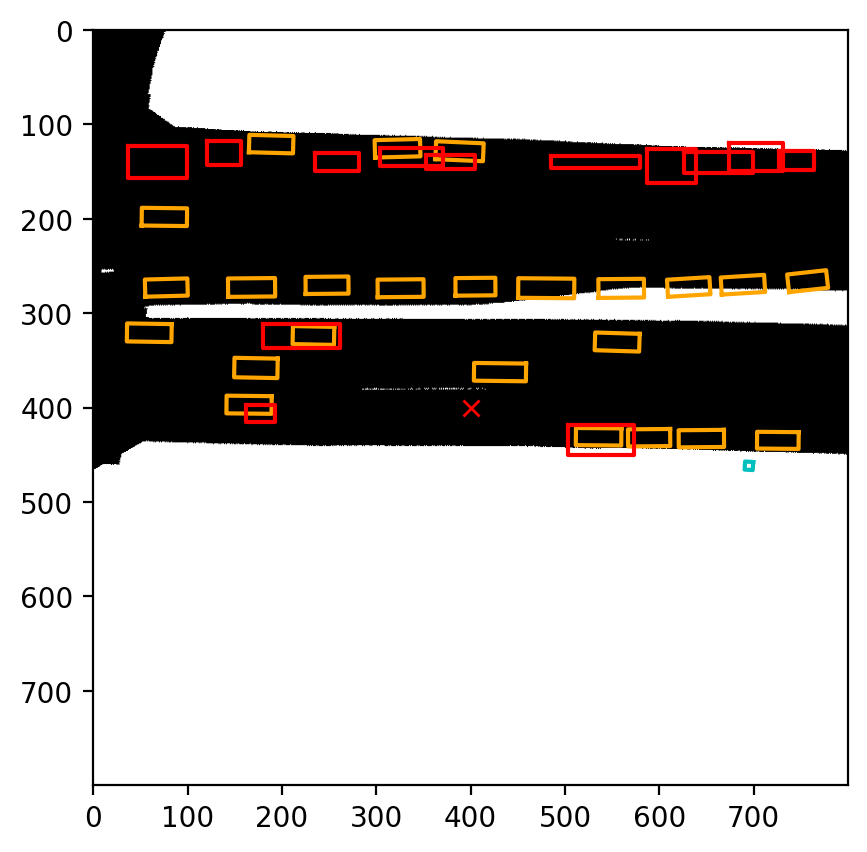

In [36]:
# The center of image is 400 * 400

fig, ax = plt.subplots()

color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']

ax.imshow(road_image[0], cmap ='binary');

# The ego car position
ax.plot(400, 400, 'x', color="red")

for i, bb in enumerate(target[0]['bounding_box']):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax, bb, color=color_list[target[0]['category'][i]])  
    
for i, bb in enumerate(hypothesis):
    draw_box(ax, bb, color='r')  
    
fig.savefig('error2.png')

In [37]:
path

('data/scene_111/sample_38', 'data/scene_111/sample_6')

In [7]:
d1 = pickle.load(open('roadmap_preds_stitch.p', 'rb'))
d2 = pickle.load(open('bbox_preds_stitch.p', 'rb'))

In [22]:
import os
import pickle

import numpy as np
from data_helper import LabeledDataset
from torchvision import transforms
import torch

val_labeled_scene_index = pickle.load(open(
    os.path.join('data_utils', 'labeled_scene_index_val.p'), 'rb'))
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.698, 0.718, 0.730),
                             (0.322, 0.313, 0.308))
        ])
valset = LabeledDataset(image_folder='data',
                  annotation_file='data/annotation.csv',
                  scene_index=val_labeled_scene_index,
                  transform=transform,
                  extra_info=False
                 )

sample, target, road_image = valset.__getitem__(150)
img_batch = sample.unsqueeze(0).to(device)

In [157]:
sample, target, road_image = valset.__getitem__(150)
img_batch = sample.unsqueeze(0).to(device)
with torch.no_grad():
    hypothesis = loss.decode(model(img_batch)[0], conf_thresh = 0.45).detach().cpu() 

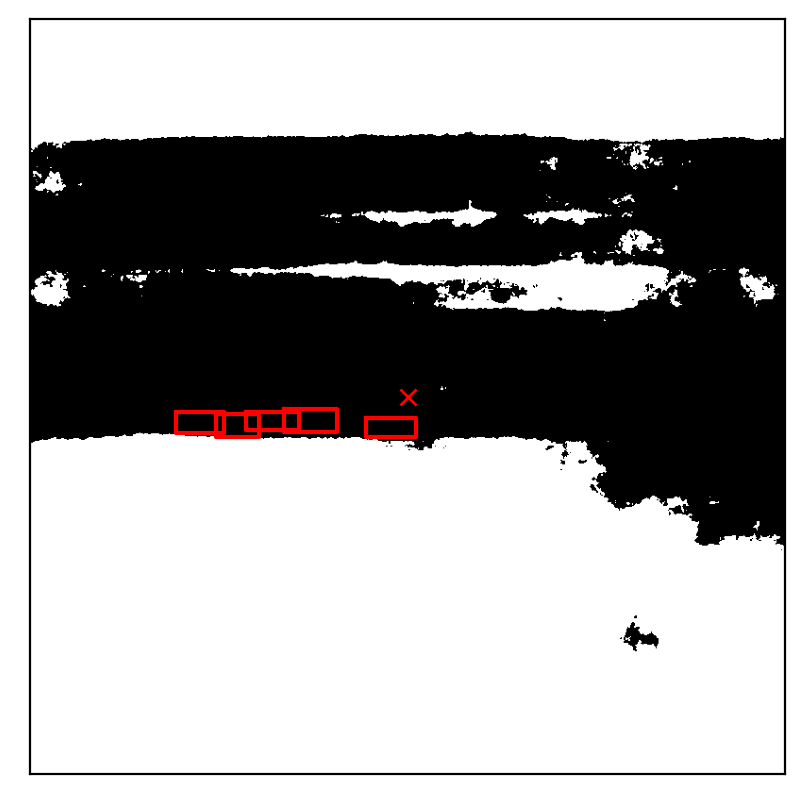

In [24]:
# The center of image is 400 * 400

fig, ax = plt.subplots()

color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']

ax.imshow(d1[150].squeeze(0), cmap ='binary');

# The ego car position
ax.plot(400, 400, 'x', color="red")
    
for i, bb in enumerate(d2[150]):
    draw_box(ax, bb, color='r')  
plt.xticks([], [])
plt.yticks([], [])
fig.savefig('error1.png', bbox_inches = 'tight')

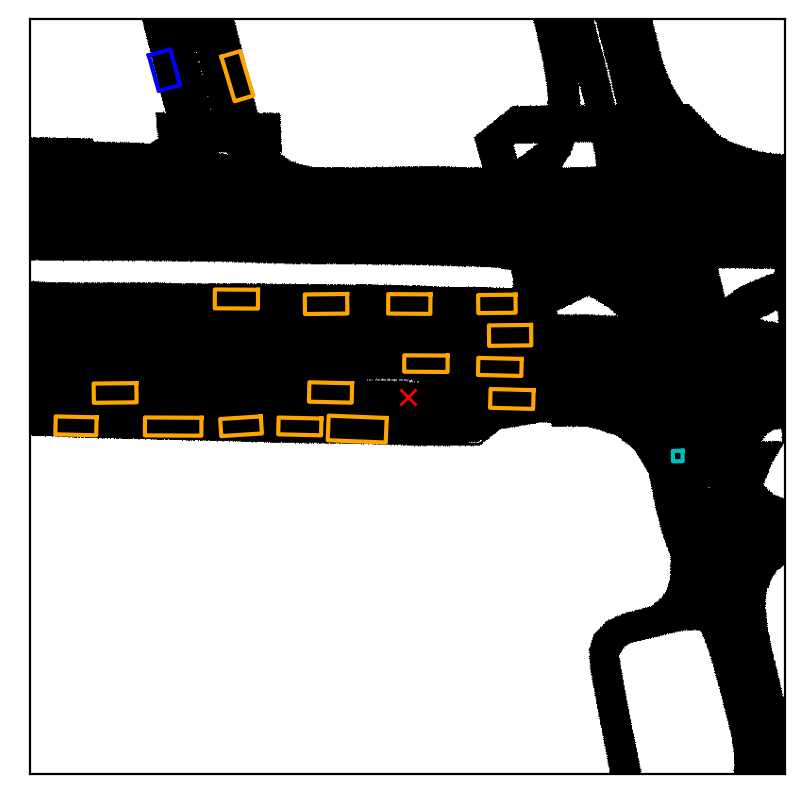

In [25]:
# The center of image is 400 * 400

fig, ax = plt.subplots()

color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']

ax.imshow(road_image, cmap ='binary');

# The ego car position
ax.plot(400, 400, 'x', color="red")

for i, bb in enumerate(target['bounding_box']):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax, bb, color=color_list[target['category'][i]])  
plt.xticks([], [])
plt.yticks([], [])
fig.savefig('plot1.png', bbox_inches = 'tight')